Dataset : https://www.kaggle.com/kaustubhb999/tomatoleaf


## Data Preparation

In [1]:
#Import Library 
import os, zipfile, shutil, PIL
import numpy as np  
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow import keras
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [2]:
#Install Kaggle
!pip install -q kaggle

In [3]:
#upload API Kaggle
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
#konfigurasi file
!chmod 600 /content/kaggle.json

In [6]:
#Download dataset
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d charuchaudhry/plantvillage-tomato-leaf-dataset

 99% 438M/443M [00:09<00:00, 63.8MB/s]
100% 443M/443M [00:09<00:00, 48.2MB/s]


In [7]:
#ekstrak zip
local_zip = '/content/plantvillage-tomato-leaf-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
#Setting direktori 
BASE_DIR = '/content/plantvillage/'

In [9]:
#Fungsi List File
def list_files(startpath):
  num_files = 0
  for root, dirs, files in os.walk(startpath):
    level = root.replace(startpath, '').count(os.sep)
    indent = ' ' * 2 * (level)
    num_files += len(files)
    print('{}{}/ {}'.format(indent, os.path.basename(root), (str(len(files)) + ' images' if len(files) > 0 else '')))
  
  return num_files

In [10]:
list_files(BASE_DIR)

/ 
Tomato___Leaf_Mold/ 761 images
plantvillage/ 
  Tomato___Leaf_Mold/ 761 images
  Tomato___Target_Spot/ 1123 images
  Tomato___Septoria_leaf_spot/ 1417 images
  Tomato___Spider_mites Two-spotted_spider_mite/ 1341 images
  Tomato___healthy/ 1273 images
  Tomato___Late_blight/ 1527 images
  Tomato___Early_blight/ 800 images
  Tomato___Tomato_mosaic_virus/ 299 images
  Tomato___Tomato_Yellow_Leaf_Curl_Virus/ 4286 images
  Tomato___Bacterial_spot/ 1702 images
Tomato___Target_Spot/ 1123 images
Tomato___Septoria_leaf_spot/ 1417 images
Tomato___Spider_mites Two-spotted_spider_mite/ 1341 images
Tomato___healthy/ 1273 images
Tomato___Late_blight/ 1527 images
Tomato___Early_blight/ 800 images
Tomato___Tomato_mosaic_virus/ 299 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus/ 4286 images
Tomato___Bacterial_spot/ 1702 images


29058

In [11]:
#Fungsi untuk membaca file
def read_files(startpath):
  image_files = []
  for dirname, dirnames, filenames in os.walk(startpath):
    for filename in filenames:
      image_files.append(os.path.join(dirname, filename))
  
  return image_files

In [12]:
#Mencek keseragaman ukuran gambar
full_dirs = read_files(BASE_DIR + "plantvillage")
image_sizes = []
for file in full_dirs:
  image = PIL.Image.open(file)
  width, height = image.size
  image_sizes.append(f'{width}x{height}')

unique_sizes = set(image_sizes)

print(f'Size all images: {len(image_sizes)}')
print(f'Size unique images: {len(unique_sizes)}')
print(f'First 10 unique images: \n{list(unique_sizes)[:10]}')

Size all images: 14529
Size unique images: 1
First 10 unique images: 
['256x256']


## DATA SPLITTING

In [13]:
#Augmentasi Gambar
datagen = ImageDataGenerator(
  rescale=1./255,
  validation_split=0.2,
  zoom_range=0.2,
  shear_range=0.2,
  rotation_range=0.2
)

In [14]:
training_generator = datagen.flow_from_directory(
  BASE_DIR + "plantvillage",
  subset='training',
  target_size=(120,120),
  seed=42,
  batch_size=64,
  interpolation='nearest',
  class_mode='categorical',
  classes=['Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight','Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus','Tomato___healthy']
)

validation_generator = datagen.flow_from_directory(
  BASE_DIR + "plantvillage",
  subset='validation',
  target_size=(120,120),
  seed=42,
  batch_size=64,
  interpolation='nearest',
  class_mode='categorical',
classes=['Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight','Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus','Tomato___healthy']
)

Found 11627 images belonging to 10 classes.
Found 2902 images belonging to 10 classes.


## MODELING DAN TRAINING


In [15]:
#fungsi Callback

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.92) and (logs.get('val_accuracy') > 0.92)):
      self.model.stop_training = True
      print("\nAkurasi training set and the validation set > 92%!")
callbacks = myCallback()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       7

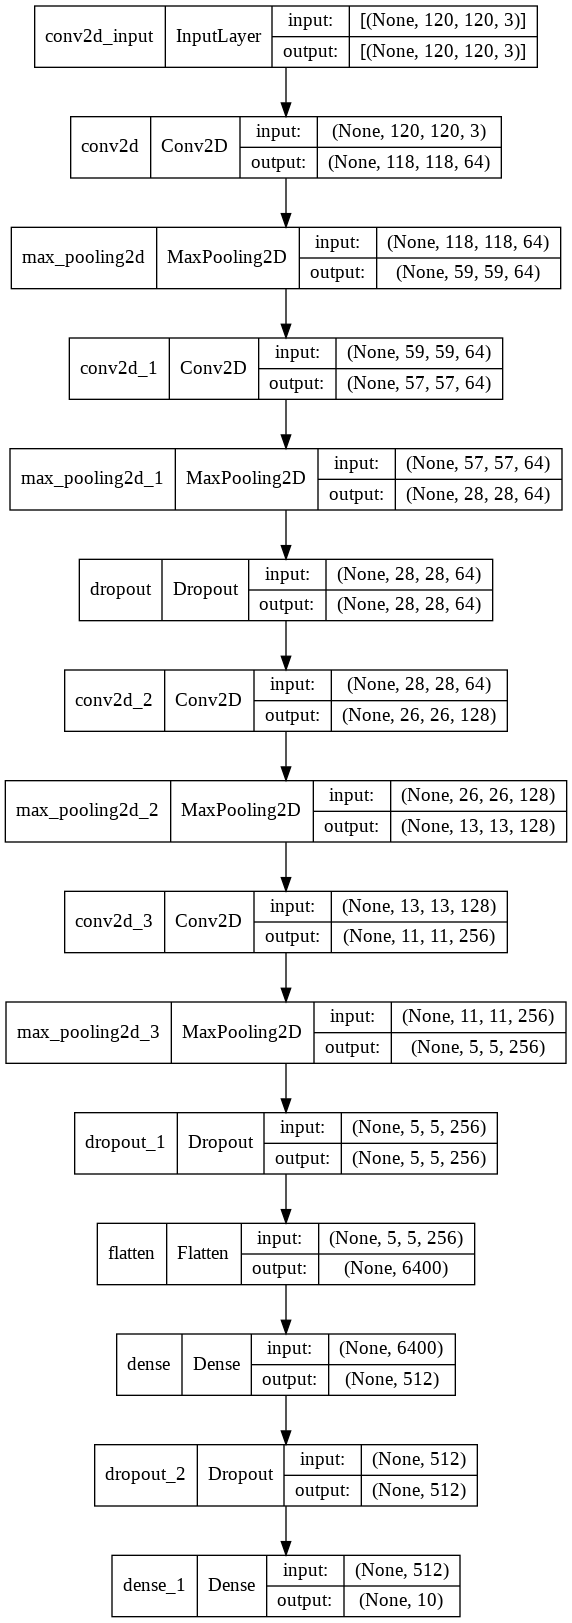

In [16]:
#membuat model
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(120, 120, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.6),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='sigmoid')
])

model.summary()

plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)




In [17]:
LR = 1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=LR),
              metrics=['accuracy'])

result = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=75,
    validation_steps=35,
    callbacks=[callbacks]
)

Epoch 1/100
75/75 [==============================] - 34s 409ms/step - loss: 1.9870 - accuracy: 0.3142 - val_loss: 1.8350 - val_accuracy: 0.3696
Epoch 2/100
75/75 [==============================] - 30s 408ms/step - loss: 1.6932 - accuracy: 0.4106 - val_loss: 1.6594 - val_accuracy: 0.4835
Epoch 3/100
75/75 [==============================] - 31s 419ms/step - loss: 1.4935 - accuracy: 0.4881 - val_loss: 1.4928 - val_accuracy: 0.5446
Epoch 4/100
75/75 [==============================] - 31s 417ms/step - loss: 1.3673 - accuracy: 0.5350 - val_loss: 1.4257 - val_accuracy: 0.5384
Epoch 5/100
75/75 [==============================] - 30s 406ms/step - loss: 1.2117 - accuracy: 0.5934 - val_loss: 1.1938 - val_accuracy: 0.6442
Epoch 6/100
75/75 [==============================] - 30s 407ms/step - loss: 1.1100 - accuracy: 0.6321 - val_loss: 1.1570 - val_accuracy: 0.6594
Epoch 7/100
75/75 [==============================] - 30s 401ms/step - loss: 0.9920 - accuracy: 0.6725 - val_loss: 1.1286 - val_accuracy:

## PLOT LOSS DAN AKURASI

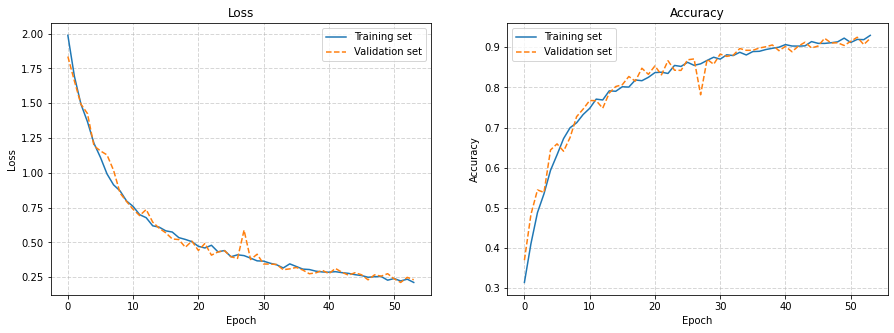

In [18]:
loss = result.history['loss']
val_loss = result.history['val_loss']
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training set')
plt.plot(val_acc, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

## EKSPOR KE TF Lite

In [21]:
    import pathlib
    # Menyimpan model dalam format SavedModel
    export_dir = 'saved_model/'
    tf.saved_model.save(model, export_dir)
     
    # Convert SavedModel menjadi tomato.tflite
    converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
    tflite_model = converter.convert()
     
    tflite_model_file = pathlib.Path('tomato.tflite')
    tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


14764952